<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [27]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn

In [28]:
#Libreria standard
import os                               #file e cartelle
import numpy as np                      #operazioni matriciali, audio e spet sono matrici
import pandas as pd                     #leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         #grafici std
import seaborn as sns                   #grafici statistici più belli

#Audio
import librosa                          #per audio in python, calcola features ecc
import librosa.display                  #visualizzare spettrogrammi
import torchaudio                       #audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       #Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          #gestire audio a livello più "umano"

#Deep learning e SNN
import torch                            #costruzioni reti neurali
import snntorch as snn                  #estensione pytorch per SNN
from snntorch import spikegen           #converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 #costruzione e training di modelli di ml e dl
from sklearn.model_selection import train_test_split

#Altri
from tqdm import tqdm                   #aggiungere barre di progresso ai loop, quanto manca al caricamento audio


Collegamento al drive

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [30]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [31]:
%ls /content/drive/MyDrive/HumanData/ESC-50/


airplane/        cow/               glass_breaking/   sheep/
breathing/       crackling_fire/    hand_saw/         siren/
brushing_teeth/  crickets/          helicopter/       sneezing/
can_opening/     crow/              hen/              snoring/
car_horn/        crying_baby/       insects/          thunderstorm/
cat/             dog/               keyboard_typing/  toilet_flush/
chainsaw/        door_wood_creaks/  laughing/         train/
chirping_birds/  door_wood_knock/   mouse_click/      vacuum_cleaner/
church_bells/    drinking_sipping/  pig/              washing_machine/
clapping/        engine/            pouring_water/    water_drops/
clock_alarm/     fireworks/         rain/             wind/
clock_tick/      footsteps/         rooster/
coughing/        frog/              sea_waves/


## Processare tutti i file audio di ESC10

In [53]:
base_path = '/content/drive/MyDrive/HumanData/ESC-10'
sample_rate = 44100  # non fare downsampling
duration = 5.0       # lunghezza standard (secondi)

In [52]:
def load_audio_file(file_path, sr=44100, duration=5.0):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y, _ = librosa.effects.trim(y)          # rimuove silenzi
    y = librosa.util.normalize(y)           # normalizzazione RMS
    if len(y) < int(sr * duration):
        padding = int(sr * duration) - len(y)
        y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

In [54]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(base_path))  # lista classi ordinate
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(base_path, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=sample_rate, duration=duration)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

Caricamento Audio: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [55]:
X_audio = np.array(X_audio)
y_labels = np.array(y_labels)

print("Forma X:", X_audio.shape)
print("Forma y:", y_labels.shape)


Forma X: (400, 220500)
Forma y: (400,)


In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

tolgo il silenzio? su esc10 si su esc50 no ?
metto noise injection?
noise = np.random.normal(0, 0.005, y.shape)
  y_noisy = y + noise
  augmented.append(y_noisy)

In [62]:
def naa(y, sr):
  augmented = []
  augmented.append(y)
  #PPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
  #NPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
  #Slow Time Stretching
  augmented.append(librosa.effects.time_stretch(y, rate=0.7))
  #Fast Time Streatching
  augmented.append(librosa.effects.time_stretch(y, rate=1.2))
  return augmented

In [63]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=sample_rate)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [02:35<00:00,  1.80it/s]


In [65]:
X_train = np.array(X_train_aug)
y_train = np.array(y_train_aug)

print("X_train_total shape:", X_train.shape)
print("y_train_total shape:", y_train.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1400,) + inhomogeneous part.

In [36]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


## LOGMELSPEC
Applica a ogni set la funzione:

In [ ]:
def batch_preprocess(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Creazione log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel_list.append(mel)
    return np.array(mel_list)


In [ ]:
X_train_mel = batch_preprocess(X_train_total)
X_val_mel = batch_preprocess(X_val)
X_test_mel = batch_preprocess(X_test)


In [ ]:
print("Train shape:", X_train_mel.shape)
print("Val shape:", X_val_mel.shape)
print("Test shape:", X_test_mel.shape)

Visualizzare un esempio

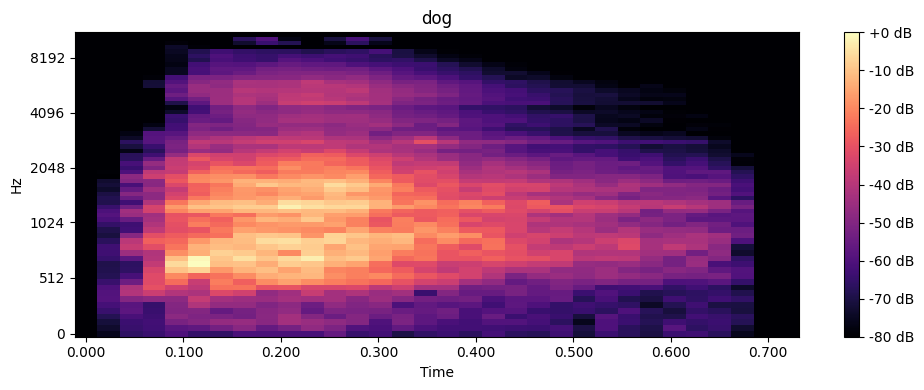

In [38]:
mel, label = data[0]
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(label)
plt.tight_layout()
plt.show()

I dati sono di lunghezza variabile a causa del trimming del silenzio --> devo uniformare la dimensione degli input per poterli elaborare in batch di modelli di dl. La possibile strategia potrebbe essere: padding

In [42]:
max_len = max([mel.shape[1] for mel in X])

def pad_mel(mel, max_len):
  if mel.shape[1] < max_len:
    pad_width = max_len - mel.shape[1]
    mel = np.pad(mel, pad_width=((0,0), (0, pad_width)), mode='constant', constant_values=-80)
  else:
    mel = mel[:, :max_len]
  return mel

In [43]:
X_padded = [pad_mel(mel, max_len) for mel in X]

In [48]:
X_array = np.array(X_padded)
y_array = np.array(y)

Salvataggio dei due array su '/content/drive/MyDrive/HumanData/esc10_data.npz'

In [ ]:
np.savez('/content/drive/MyDrive/HumanData/esc10_data_aug.npz', X=X_array, y=y_array)

In [50]:
dataset = tf.data.Dataset.from_tensor_slices((X_array, y_array))

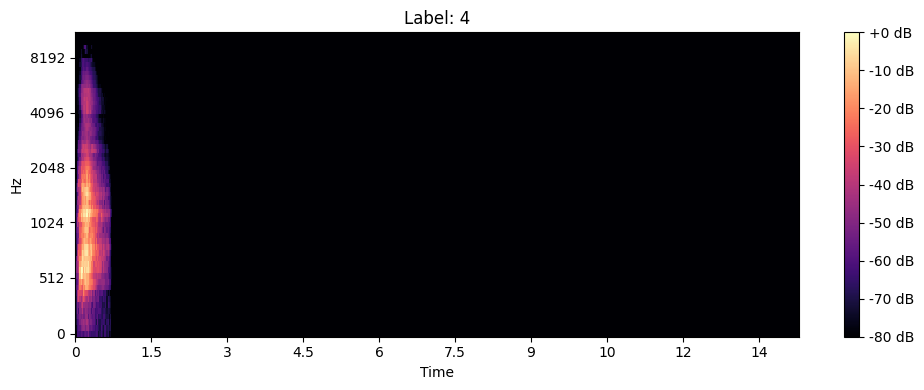

In [51]:
for mel, label in dataset.take(3):
    mel = mel.numpy()
    label = label.numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, x_axis='time', y_axis='mel', cmap='magma')
plt.title(f"Label: {label}")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()